In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from datetime import datetime
import os
import matplotlib.pyplot as plt

In [3]:
model_path = "mnist.pt"

In [4]:
train_transform = transforms.Compose(
    [
     transforms.Resize((32, 32)), # MNIST  is 28x28 for conveniencewe will make it 32x32
     #transforms.RandomRotation(degrees=15), # Now that we are in inference we won't augment the data. I leave this line just for reminder
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

val_transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])


np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

train_set = datasets.MNIST(root = ".",train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=0)

val_set = datasets.MNIST(root = ".",train=False,
                                       download=True, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128,
                                         shuffle=False, num_workers=0)

train_set_size = len(train_set)
print("Train set size:", train_set_size)
val_set_size = len(val_set)
print("Val set size:", val_set_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 90078650.90it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40663207.06it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32308040.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17334421.08it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Train set size: 60000
Val set size: 10000


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # checks if there is gpu available

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Sample image shape ", images.shape)
print("Sample labels shape", labels.shape)

Sample image shape  torch.Size([128, 1, 32, 32])
Sample labels shape torch.Size([128])


In [7]:
def imshow(img):
   img = (img + 1) / 2     # unnormalize
   img = img.numpy()
   plt.imshow(np.transpose(img, (1, 2, 0)))
   plt.show()

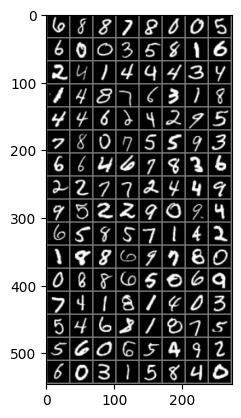

In [8]:
imshow(torchvision.utils.make_grid(images))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(1, 16, 3,stride=1,padding=0),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.conv_l2 = nn.Sequential(
            nn.Conv2d(16, 32, 3,stride=1,padding=2),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.conv_l3 = nn.Sequential(
            nn.Conv2d(32, 32, 3,stride=1,padding=2),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )

        self.fc = nn.Sequential(nn.Linear(5*5*32, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_l1(x)
        x = self.conv_l2(x)
        x = self.conv_l3(x)
        x = x.view(-1, 5 * 5 * 32)
        x = self.fc(x)

        return x

In [10]:
model = Net()

dataiter = iter(train_loader)
images, labels = next(dataiter)
out = model(images)
print(out.shape)

torch.Size([128, 10])


In [11]:
if device == "cuda":
  model.load_state_dict(torch.load(model_path)["model_state_dict"])
else:
  model.load_state_dict(torch.load(model_path,map_location = torch.device('cpu'))["model_state_dict"])

model.to(device)
model.eval()

Net(
  (conv_l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_l3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [12]:
loader_dict = {"train":train_loader,"val":val_loader}
conf_mat_dict = {"train":[],"val":[]}
feature_list = []
gold_label_list = []

num_classes = 10

for key in loader_dict.keys():
    loader = loader_dict[key]
    confusion_matrix = torch.zeros(num_classes,num_classes)
    for sample in tqdm(loader):
        inputs ,labels = sample
        batch_size = inputs.size(0)

        inputs = inputs.to(device)
        labels = labels.long()

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        for i in range(labels.size(0)):
          confusion_matrix[labels[i],preds.detach().cpu()[i]] +=1

        if key == "val": # we will calculate confusion matrix and T-sne only for validation
            gold_label_list.append(labels.detach().cpu())

    conf_mat_dict[key] = confusion_matrix
    if key == "val":
        gold_label_tensor = torch.cat(gold_label_list)

100%|██████████| 79/79 [00:07<00:00, 10.78it/s]


In [13]:
gold_label_tensor = torch.cat(gold_label_list)

In [14]:
import seaborn as sns

In [15]:
mat_tra = conf_mat_dict["train"]/conf_mat_dict["train"].sum(axis=1)[:,None]
mat_val = conf_mat_dict["val"]/conf_mat_dict["val"].sum(axis=1)[:,None]#normalize

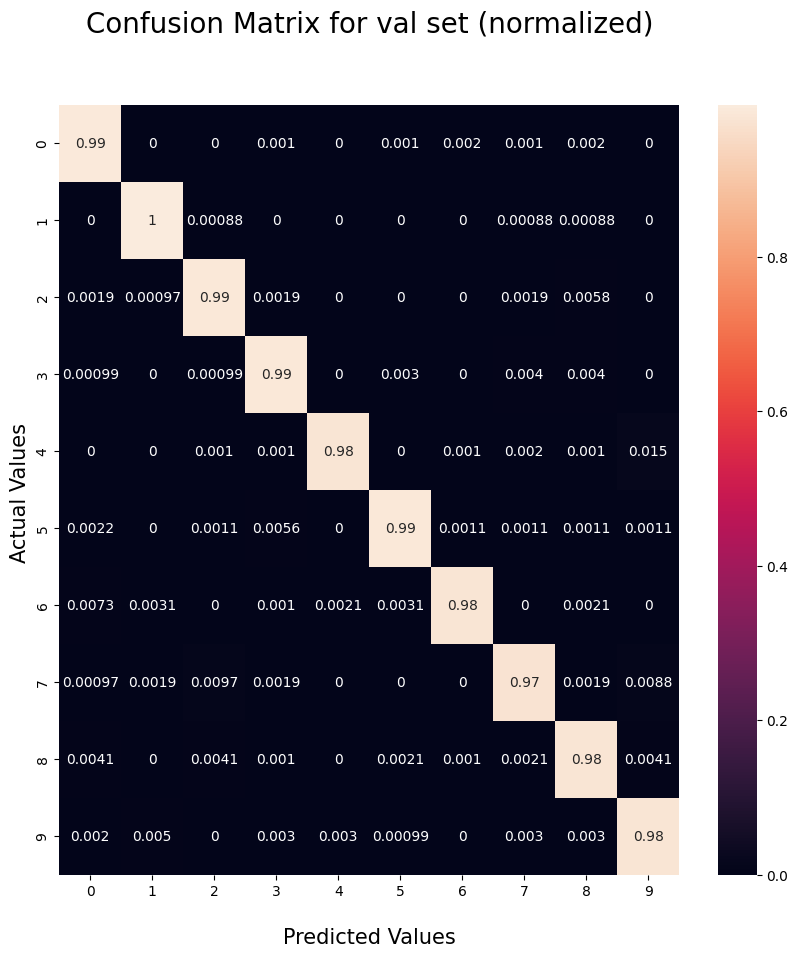

In [16]:
label_list =  np.arange(10)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(mat_val, annot=True)#, cmap='Blues')

ax.set_title('Confusion Matrix for val set (normalized)\n\n',fontsize=20)
ax.set_xlabel('\nPredicted Values',fontsize=15)
ax.set_ylabel('Actual Values ',fontsize=15)

ax.xaxis.set_ticklabels(label_list,fontsize=10)
ax.yaxis.set_ticklabels(label_list,fontsize=10)
plt.show()

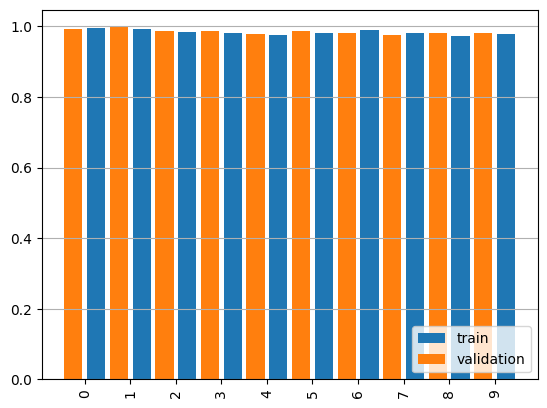

In [17]:
c = np.arange(0,20)
single = c[c%2!=0]
doble = c[c%2!=1]

plt.xticks(single-0.5,label_list,rotation=90,fontsize=10)
plt.bar(single,mat_tra.diag())
plt.bar(doble,mat_val.diag())
plt.legend(["train","validation"],loc='lower right')
plt.grid(axis="y")
plt.show()

In [18]:
from torchvision.models.feature_extraction import create_feature_extractor
print(model.fc)
return_nodes = {
    "fc.1": "fc"
}

Sequential(
  (0): Linear(in_features=800, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
feture_extractor_model = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = feture_extractor_model(torch.rand(1,1,32,32))

In [20]:
feature_list = []
gold_label_list = []

num_classes = 10

for sample in tqdm(val_loader):
    inputs ,labels = sample
    batch_size = inputs.size(0)

    inputs = inputs.to(device)
    labels = labels.long()

    intermediate_outputs = feture_extractor_model(inputs)["fc"]
    feature_list.append(intermediate_outputs)
    gold_label_list.append(labels)

feature__tensor = torch.cat(feature_list)
gold_label_tensor = torch.cat(gold_label_list)

100%|██████████| 79/79 [00:08<00:00,  9.75it/s]


In [21]:
print(feature__tensor.shape)

torch.Size([10000, 256])


In [22]:
from sklearn.manifold import TSNE

In [23]:
X_embedded = TSNE(n_components=2).fit_transform(feature__tensor.detach())
X_embedded.shape

(10000, 2)

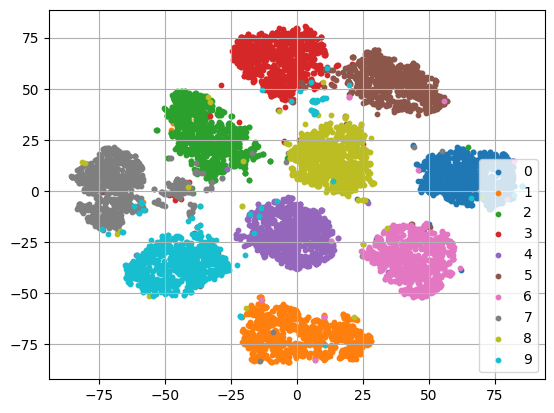

In [24]:
fig, ax = plt.subplots()

group = gold_label_tensor.reshape(1,-1).squeeze(0).numpy()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_embedded[:,0][ix], X_embedded[:,1][ix], label = g, s = 10)
ax.legend(label_list)
plt.grid()